In [2]:
# Import custom functions to load windsat data
import matplotlib.pyplot as plt
import xarray as xr
import os
import sys
sys.path.append("../")
from src.processing import windsat_datacube

# Results will be saved here
save_path = r"../data/processed/"

# Folder with the data
folder_path = r"../data/raw/daily_Windsat"


In [3]:
ds = windsat_datacube(folder_path)
ds

<xarray.Dataset> Size: 3GB
Dimensions:         (day_number: 32, longitude_grid: 1440, latitude_grid: 720,
                     swath_sector: 2, frequency_band: 2, polarization: 2)
Coordinates:
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
  * day_number      (day_number) int32 128B 1 2 3 4 5 6 7 ... 27 28 29 30 31 32
Dimensions without coordinates: longitude_grid, latitude_grid, swath_sector,
                                frequency_band, polarization
Data variables:
    longitude       (day_number, longitude_grid) float32 184kB dask.array<chunksize=(1, 1440), meta=np.ndarray>
    latitude        (day_number, latitude_grid) float32 92kB dask.array<chunksize=(1, 720), meta=np.ndarray>
    node            (day_number, swath_sector) int32 256B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_vpol  (day_number, frequency_band) float32 256B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_hpol  (day_number, frequency_band) float32 256B dask.array<chunksize=(1, 2), meta=np.ndarray>
    eia_nominal     (day_number, frequency_band) float32 256B dask.array<chunksize=(1, 2), meta=np.ndarray>
    time            (day_number, frequency_band, latitude_grid, longitude_grid, swath_sector) float64 1GB dask.array<chunksize=(1, 1, 240, 480, 1), meta=np.ndarray>
    eaa             (day_number, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 531MB dask.array<chunksize=(1, 1, 360, 720, 1), meta=np.ndarray>
    eia             (day_number, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 531MB dask.array<chunksize=(1, 1, 360, 720, 1), meta=np.ndarray>
    tbtoa           (day_number, polarization, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 1GB dask.array<chunksize=(1, 1, 1, 240, 480, 1), meta=np.ndarray>
    quality_flag    (day_number, latitude_grid, longitude_grid, swath_sector) int32 265MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [4]:
# Get the number of measurements per pixel
tbtoa_count = ds.tbtoa.count(dim = "day_number")
tbtoa_count.attrs = {
    "Description" : "Total count of measurements in the whole datset",
}
save_into = os.path.join(save_path, "tbtoa_count.nc")
tbtoa_count.to_netcdf(save_into)
print(f"TBToA count saved in {save_into}")
tbtoa_count

TBToA count saved in ../data/processed/tbtoa_count.nc


<xarray.DataArray 'tbtoa' (polarization: 2, frequency_band: 2,
                           latitude_grid: 720, longitude_grid: 1440,
                           swath_sector: 2)> Size: 33MB
dask.array<sum-aggregate, shape=(2, 2, 720, 1440, 2), dtype=int32, chunksize=(1, 1, 240, 480, 1), chunktype=numpy.ndarray>
Coordinates:
    lat      (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon      (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
Dimensions without coordinates: polarization, frequency_band, latitude_grid,
                                longitude_grid, swath_sector
Attributes:
    Description:  Total count of measurements in the whole datset

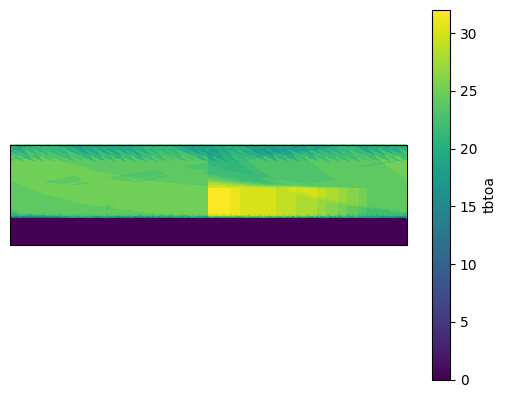

In [52]:
# WIP
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, ax = plt.subplots(1,1, subplot_kw={'projection': ccrs.PlateCarree()})
tbtoa_count.sel(polarization = 0, frequency_band=0, swath_sector=0).plot(ax=ax)


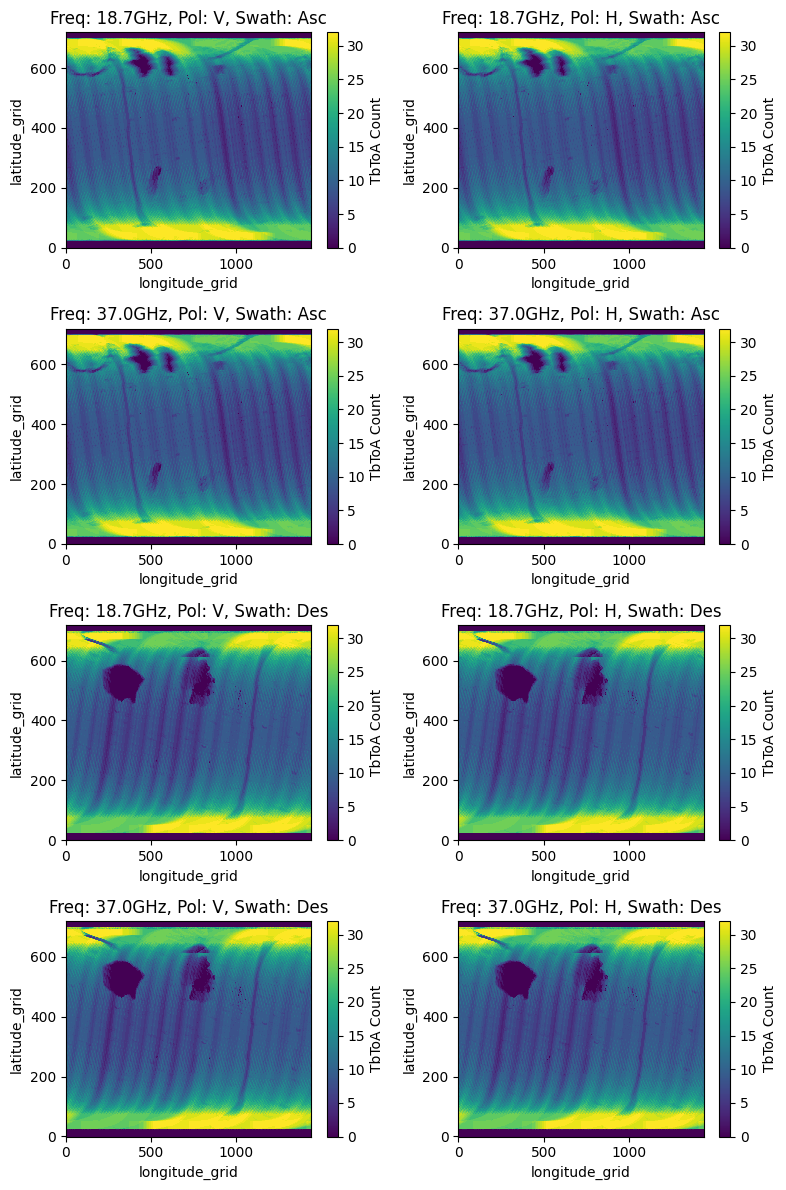

In [10]:
# Custom function
def dimensional_plot(ds: xr.DataArray, save_path: str = None, cbar_label: str = None)-> None:
    """ 
    Given a data_array, plot each combination of:
        polarization : [0,1]
        frequency: [0,1]
        swath_sector : [0,1]

    param save_path: if not None, atempt to save the plot with the given path
    param cbar_label: if not None, swap the default xarray.plot label for it
    """

    dimension_dict ={
        "polarization": {0:"V", 1:"H"},
        "frequency": {0:"18.7GHz", 1:"37.0GHz"},
        "sector": {0:"Asc", 1:"Des"},
    }

    fig, axs = plt.subplots(4,2, figsize = (8,12))

    plot_number = 0
    for sector in range(0,2,1):
        for freq in range(0,2,1):
            for pol in range(0,2,1):
                nrow = plot_number // 2
                ncol = plot_number % 2
                ax = axs[nrow,ncol]
                
                # Plot data
                plot = ds.sel(
                    polarization = pol,
                    frequency_band=freq,
                    swath_sector=sector
                    ).plot(ax=ax)
                
                # TODO: Add coastline 
                """ 
                Data is in 1/4º grid, cartopy uses latitude and longitude.
                    - Change the grid
                    OR
                    - Change the coastline feature somehow.
                """
                # ax.coastlines(resolution="110m", color = "white", linewidth=1)
                
                ax.set_title(
                    f"Freq: {dimension_dict['frequency'][freq]}, " \
                    f"Pol: {dimension_dict['polarization'][pol]}, " \
                    f"Swath: {dimension_dict['sector'][sector]}"
                )
                if cbar_label:
                    colorbar= plot.colorbar
                    colorbar.set_label(cbar_label)

                plot_number += 1
    
    fig.tight_layout()
    if save_path:
        try:
            fig.savefig(save_path)
        except Exception as e:
            print(f"Unable to save plot: {e}")

    return

dimensional_plot(tbtoa_count, cbar_label= "TBToA Count")

In [11]:
dimensional_plot(tbtoa_count, save_path="../data/processed/tbtoa_count.png", cbar_label= "TBToA Count")